In [225]:

import boto3
# print(f"SageMaker Version: {sagemaker.__version__}")
# print(f"Installation Path: {sagemaker.__file__}")
import sagemaker
from sagemaker.pytorch import PyTorch
from io import BytesIO
from botocore.exceptions import ClientError
from PIL import Image 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from io import StringIO

import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

import os
from scipy.stats import norm
# Get the caller identity
sts_client = boto3.client('sts')

identity = sts_client.get_caller_identity()
arn = identity['Arn']
username = arn.split('/')[-1]
import botocore
from tqdm import tqdm
import os
import time
import sys
print(f"Account: {identity['Account']}")
print(f"UserId: {identity['UserId']}")
print(f"ARN: {identity['Arn']}")
print(f"Your AWS Username is: {username}")


Account: 253490779227
UserId: AIDATWBJ2KRN6C42QYYWF
ARN: arn:aws:iam::253490779227:user/amannindra2
Your AWS Username is: amannindra2


In [226]:
# REPLACE THIS STRING with the actual Role ARN you created in IAM
# role = "arn:aws:iam::253490779227:role/service-role/AmazonSageMakerAdminIAMExecutionRole" 
# boto_session = boto3.Session(region_name='us-west-1')
# sagemaker_session = sagemaker.Session(boto_session=boto_session)

# print(f"SageMaker Session Region: {sagemaker_session.boto_region_name}")
# print(f"Default Bucket: {sagemaker_session.default_bucket()}")

In [227]:
s3 = boto3.client("s3")

bucket_name = "animal-classification-virgina"
train_folder = "processed/train_features"
test_folder = "processed/test_features"
train_features_csv = "processed/train_features.csv"
test_features_csv = "processed/test_features.csv"
train_labels_csv = "processed/train_labels.csv"

response = s3.list_objects_v2(Bucket=bucket_name)


train_labels = s3.get_object(
    Bucket=bucket_name, Key = train_labels_csv
)

content_labels = train_labels["Body"].read().decode("utf-8")
content_labels = StringIO(content_labels)
df_labels = pd.read_csv(content_labels)
df_labels


id  antelope_duiker  bird  blank  civet_genet  hog  leopard  \
0      ZJ000000              0.0   1.0    0.0          0.0  0.0      0.0   
1      ZJ000001              0.0   0.0    0.0          0.0  0.0      0.0   
2      ZJ000002              0.0   1.0    0.0          0.0  0.0      0.0   
3      ZJ000003              0.0   0.0    0.0          0.0  0.0      0.0   
4      ZJ000004              0.0   0.0    0.0          0.0  0.0      1.0   
...         ...              ...   ...    ...          ...  ...      ...   
16483  ZJ016483              0.0   0.0    1.0          0.0  0.0      0.0   
16484  ZJ016484              0.0   0.0    0.0          0.0  0.0      1.0   
16485  ZJ016485              0.0   0.0    0.0          1.0  0.0      0.0   
16486  ZJ016486              0.0   1.0    0.0          0.0  0.0      0.0   
16487  ZJ016487              0.0   0.0    0.0          1.0  0.0      0.0   

       monkey_prosimian  rodent  
0                   0.0     0.0  
1                   1.0     0.0  
2                   0.0     0.0  
3                   1.0     0.0  
4                   0.0     0.0  
...                 ...     ...  
16483               0.0     0.0  
16484               0.0     0.0  
16485               0.0     0.0  
16486               0.0     0.0  
16487               0.0     0.0  

[16488 rows x 9 columns]

In [228]:
col = df_labels.columns
print(type(col), col)
col = col.drop(col[0])
print(col)

<class 'pandas.core.indexes.base.Index'> Index(['id', 'antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog',
       'leopard', 'monkey_prosimian', 'rodent'],
      dtype='object')
Index(['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard',
       'monkey_prosimian', 'rodent'],
      dtype='object')


In [229]:
count = {}



for i in col:
    count[i] = len(df_labels[df_labels[i] == 1.0])
    print(f"There are {count[i]} images of {i}")
count


There are 2474 images of antelope_duiker
There are 1641 images of bird
There are 2213 images of blank
There are 2423 images of civet_genet
There are 978 images of hog
There are 2254 images of leopard
There are 2492 images of monkey_prosimian
There are 2013 images of rodent


{'antelope_duiker': 2474,
 'bird': 1641,
 'blank': 2213,
 'civet_genet': 2423,
 'hog': 978,
 'leopard': 2254,
 'monkey_prosimian': 2492,
 'rodent': 2013}

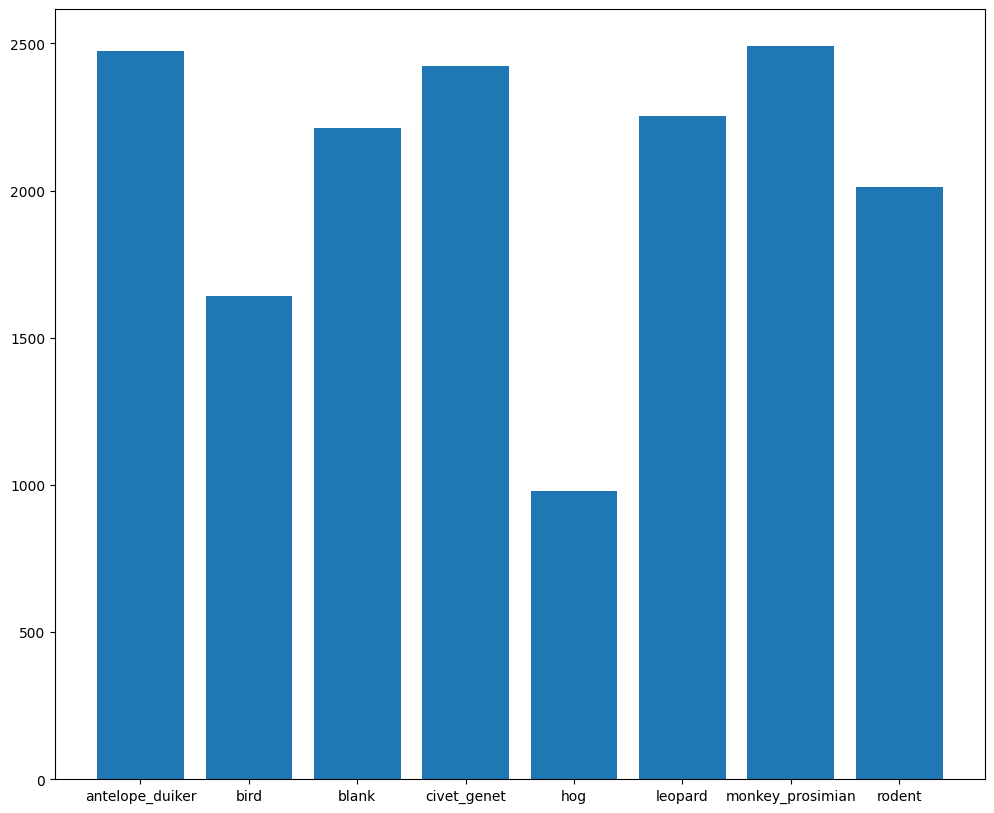

In [230]:
fig, ax = plt.subplots(figsize=(12, 10))

plt.bar(count.keys(), count.values())
plt.show()


In [231]:
train_features = s3.get_object(
    Bucket=bucket_name, Key = train_features_csv
)
content_features = train_features["Body"].read().decode("utf-8")
content_features = StringIO(content_features)
df_features = pd.read_csv(content_features)
df_features



id                     filepath   site
0      ZJ000000  train_features/ZJ000000.jpg  S0120
1      ZJ000001  train_features/ZJ000001.jpg  S0069
2      ZJ000002  train_features/ZJ000002.jpg  S0009
3      ZJ000003  train_features/ZJ000003.jpg  S0008
4      ZJ000004  train_features/ZJ000004.jpg  S0036
...         ...                          ...    ...
16483  ZJ016483  train_features/ZJ016483.jpg  S0093
16484  ZJ016484  train_features/ZJ016484.jpg  S0043
16485  ZJ016485  train_features/ZJ016485.jpg  S0089
16486  ZJ016486  train_features/ZJ016486.jpg  S0095
16487  ZJ016487  train_features/ZJ016487.jpg  S0021

[16488 rows x 3 columns]

In [232]:
test_features = s3.get_object(
    Bucket=bucket_name, Key = test_features_csv
)
content_test_features = test_features["Body"].read().decode("utf-8")
content_test_features = StringIO(content_test_features)
df_test_features = pd.read_csv(content_test_features)
df_test_features


id                    filepath   site
0     ZJ016488  test_features/ZJ016488.jpg  S0082
1     ZJ016489  test_features/ZJ016489.jpg  S0040
2     ZJ016490  test_features/ZJ016490.jpg  S0040
3     ZJ016491  test_features/ZJ016491.jpg  S0041
4     ZJ016492  test_features/ZJ016492.jpg  S0040
...        ...                         ...    ...
4459  ZJ020947  test_features/ZJ020947.jpg  S0086
4460  ZJ020948  test_features/ZJ020948.jpg  S0152
4461  ZJ020949  test_features/ZJ020949.jpg  S0162
4462  ZJ020950  test_features/ZJ020950.jpg  S0055
4463  ZJ020951  test_features/ZJ020951.jpg  S0114

[4464 rows x 3 columns]

In [233]:
# s3://animal-classification-dss-works/data/train_features/ZJ000000.jpg

# def get_image_keys_with_paginator(bucket, prefix):
#     """Get all image keys using boto3 paginator"""
#     image_keys = []
    
#     # Create paginator
#     paginator = s3.get_paginator('list_objects_v2')
#     pages = paginator.paginate(Bucket=bucket, Prefix=prefix)
    
#     # Iterate through all pages
#     for page in pages:
#         for obj in page.get('Contents', []):
#             key = obj['Key']
#             if key.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
#                 image_keys.append(key)
    
#     return image_keys

# def get_image_array(image_key: str) -> np.ndarray:
#     # image_key = os.path.join(train_folder, image_key)
#     image_obj = s3.get_object(
#         Bucket=bucket_name, Key = image_key
#     )
#     image_data = image_obj["Body"].read()
#     image = Image.open(BytesIO(image_data))
#     return np.array(image)


# def get_image_size(image_key: str) -> tuple[int, int]:
#     image_obj = s3.get_object(
#         Bucket=bucket_name, Key = image_key
#     )
#     image_data = image_obj["Body"].read()
#     image = Image.open(BytesIO(image_data))
#     return image.size


# def get_image_(image_key: str) -> bool:
#     image_obj = s3.get_object(
#         Bucket=bucket_name, Key = image_key
#     )
#     image_data = image_obj["Body"].read()
#     image = Image.open(BytesIO(image_data))
#     return [image.mode == 'RGB', image.size]

def get_image_from_s3(name_bucket, key):
    """Get image from S3 without downloading to disk"""
    try:
        # key = os.path.join("data", key)
        print(key)
        response = s3.get_object(Bucket=name_bucket, Key=key)
        image = Image.open(BytesIO(response["Body"].read()))
        return image
    except Exception as e:
        print(f"Error loading, {e}")
        return None


train_keys = df_features['filepath']
print(train_keys[:5])

count_rgb = 0
count_grayscale = 0
size = []
for i in range(100):
    try:
        r = os.path.join("data", train_keys[i])
        image = get_image_from_s3(bucket_name, r)
        size.append(image.size)
        if image.mode == 'RGB':
            count_rgb += 1
        else:
            count_grayscale += 1
    except Exception as e:
        print(f"Error: {e}")
        print(f"Image key: {train_keys[i]}")
    if i % 10 == 0:
        print(i)
print(f"RGB: {count_rgb}")
print(f"GRAYSCALE: {count_grayscale}")
print(f"There are {count_rgb/1000:.2f}% of RGB images")
print(f"There are {count_grayscale/1000:.2f}% of GRAYSCALE images")

print(size[:20])




# image_key = "ZJ000000.jpg"

# train_images = get_image_keys_with_paginator(bucket_name, 'data/test_features/')
# print(train_images)
# image_array = []
# print(f"length: {len(train_images)}")
# for i in range(len(train_images)):
#     image_array.append(get_image_array(train_images[i]))
#     if i % 100 == 0:
#         print(i)
    

# print(len(image_array))
# print(image_array)




0    train_features/ZJ000000.jpg
1    train_features/ZJ000001.jpg
2    train_features/ZJ000002.jpg
3    train_features/ZJ000003.jpg
4    train_features/ZJ000004.jpg
Name: filepath, dtype: object
data/train_features/ZJ000000.jpg
0
data/train_features/ZJ000001.jpg
data/train_features/ZJ000002.jpg
data/train_features/ZJ000003.jpg
data/train_features/ZJ000004.jpg
data/train_features/ZJ000005.jpg
data/train_features/ZJ000006.jpg
data/train_features/ZJ000007.jpg
data/train_features/ZJ000008.jpg
data/train_features/ZJ000009.jpg
data/train_features/ZJ000010.jpg
10
data/train_features/ZJ000011.jpg
data/train_features/ZJ000012.jpg
data/train_features/ZJ000013.jpg
data/train_features/ZJ000014.jpg
data/train_features/ZJ000015.jpg
data/train_features/ZJ000016.jpg
data/train_features/ZJ000017.jpg
data/train_features/ZJ000018.jpg
data/train_features/ZJ000019.jpg
data/train_features/ZJ000020.jpg
20
data/train_features/ZJ000021.jpg
data/train_features/ZJ000022.jpg
data/train_features/ZJ000023.jpg
data/

In [234]:
size

[(960, 540),
 (960, 540),
 (640, 360),
 (640, 360),
 (640, 335),
 (960, 540),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 515),
 (640, 335),
 (640, 360),
 (160, 120),
 (960, 540),
 (640, 360),
 (640, 360),
 (360, 215),
 (160, 120),
 (360, 240),
 (640, 360),
 (360, 215),
 (960, 540),
 (640, 360),
 (960, 515),
 (640, 360),
 (960, 540),
 (640, 360),
 (960, 540),
 (360, 240),
 (960, 540),
 (640, 360),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 540),
 (960, 540),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 540),
 (960, 540),
 (360, 240),
 (360, 240),
 (960, 540),
 (960, 540),
 (640, 360),
 (640, 360),
 (640, 360),
 (640, 360),
 (960, 540),
 (960, 540),
 (640, 360),
 (360, 240),
 (960, 515),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 540),
 (640, 360),
 (640, 360),
 (640, 360),
 (640, 360),
 (960, 540),
 (640, 335),
 (640, 360),
 (960, 540),
 (960, 540),
 (960, 540),
 (960, 540),
 (960, 540),
 (640, 360),
 (960, 540),
 (640, 360),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 540),

In [235]:
width, height = [], []
for i in range(len(size)):
    width.append(size[i][0])
    height.append(size[i][1])
width = np.array(width)
height = np.array(height)


In [236]:
print(f"Width: {width.mean()}, Height: {height.mean()}")
print(f"Width: {width.std()}, Height: {height.std()}")
print(f"Width: {width.min()}, Height: {height.min()}")
print(f"Width: {width.max()}, Height: {height.max()}")


Width: 746.8, Height: 421.1
Width: 214.5920781389658, Height: 114.37346720284387
Width: 160, Height: 120
Width: 960, Height: 540


In [237]:
print(np.unique(width,return_counts=True))
print(f"most common width: {np.argmax(np.bincount(width))} with count {np.max(np.bincount(width))}")
print(np.unique(height,return_counts=True))
print(f"most common height: {np.argmax(np.bincount(height))} with count {np.max(np.bincount(height))}")

(array([160, 360, 640, 960]), array([ 3,  7, 46, 44]))
most common width: 640 with count 46
(array([120, 215, 240, 335, 360, 515, 540]), array([ 3,  2,  5,  4, 42,  4, 40]))
most common height: 360 with count 42


In [238]:
count

{'antelope_duiker': 2474,
 'bird': 1641,
 'blank': 2213,
 'civet_genet': 2423,
 'hog': 978,
 'leopard': 2254,
 'monkey_prosimian': 2492,
 'rodent': 2013}

In [239]:
train_folder

'processed/train_features'

In [240]:
# fig, axes = plt.subplots(len(count), 5, figsize=(15, 3*len(count)))
# fig.suptitle('Sample Images per Class', fontsize=16, fontweight='bold')

# for i, (class_name, num_samples) in enumerate(count.items()):
#     # Get 5 random samples from this class
#     class_samples = df_labels[df_labels[class_name] == 1].sample(min(5, num_samples))
    
#     for j, (idx, row) in enumerate(class_samples.iterrows()):
#         img_path = os.path.join(train_folder, row['id'] + ".jpg")
#         print(img_path)
#         image = get_image_from_s3(img_path)
        
#         if image is None:
#             print(f"Error loading image: {img_path}")
#             continue
        
#         print(type(image))
#         axes[i, j].imshow(image)
#         axes[i, j].axis('off')
#         if j == 0:
#             axes[i, j].set_ylabel(class_name, fontsize=10, rotation=0, ha='right')

# plt.show()

1000
1000



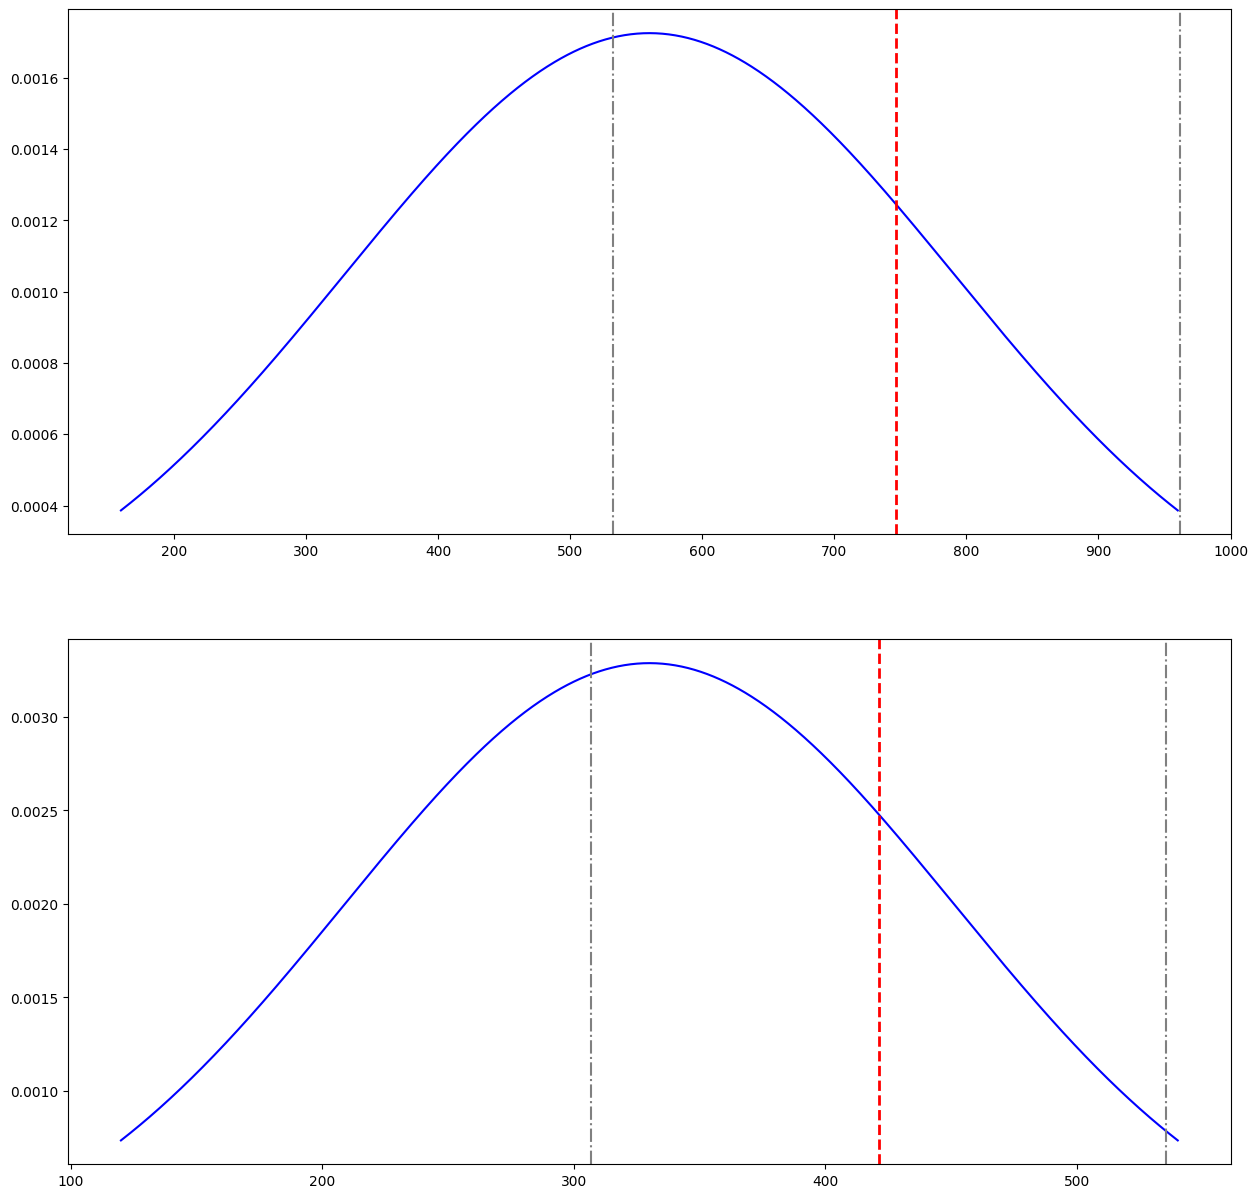

In [241]:
mean = 0
std_dev = 1


def pdf(x):
    mean = x.mean()
    std_dev = x.std()
    return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)


x_width = np.linspace(width.min(), width.max(), 1000)
x_height = np.linspace(height.min(), height.max(), 1000)

y_width = pdf(x_width)
y_height = pdf(x_height)
print(len(y_width))
print(len(y_height))

print()


fig, ax1 = plt.subplots(2, 1, figsize=(15, 15))



ax1[0].plot(x_width, y_width, 'b-', label='Normal Distribution')
ax1[1].plot(x_height , y_height, 'b-', label='Normal Distribution')

mean_w, std_w = width.mean(), width.std()
mean_h, std_h = height.mean(), height.std()

ax1[0].axvline(mean_w, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_w:.1f}')
ax1[0].axvline(mean_w + std_w, color='gray', linestyle='-.', label=f'±1 STD: {std_w:.1f}')
ax1[0].axvline(mean_w - std_w, color='gray', linestyle='-.')

ax1[1].axvline(mean_h, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_h:.1f}')
ax1[1].axvline(mean_h + std_h, color='gray', linestyle='-.', label=f'±1 STD: {std_h:.1f}')
ax1[1].axvline(mean_h - std_h, color='gray', linestyle='-.')

# ax1[0].hist(width, bins=50, density=True, alpha=0.6, color='lightblue', edgecolor='black')
# ax1[0].plot(x_width, y_width, 'r-', linewidth=2, label='PDF')

# ax1[1].hist(height, bins=50, density=True, alpha=0.6, color='lightgreen', edgecolor='black')
# ax1[1].plot(x_height, y_height, 'r-', linewidth=2, label='PDF')



# ax1.plot(x, y, 'b-', label='Normal Distribution')

# # Add vertical lines to show mean and standard deviations
# ax1.axvline(mean, color='r', linestyle='--', label='Mean')
# plt.axvline(mean + std_dev, color='gray', linestyle='-.', label='±1 STD')
# plt.axvline(mean - std_dev, color='gray', linestyle='-.')

# plt.xlabel('X')
# plt.ylabel('Probability Density')
# plt.title('Normal Distribution with Standard Deviations')
# plt.legend()
# plt.grid(True)
# plt.show()

In [242]:
test_keys = df_test_features['filepath']
test_keys[:5]

0    test_features/ZJ016488.jpg
1    test_features/ZJ016489.jpg
2    test_features/ZJ016490.jpg
3    test_features/ZJ016491.jpg
4    test_features/ZJ016492.jpg
Name: filepath, dtype: object

In [243]:
unique_sizes = list(set(size))
print(len(unique_sizes))
print(unique_sizes)



7
[(160, 120), (960, 515), (640, 335), (960, 540), (640, 360), (360, 215), (360, 240)]


In [244]:
train_keys[0]

'train_features/ZJ000000.jpg'

In [245]:
train_keys[0]

'train_features/ZJ000000.jpg'

processed/train_features/ZJ000000.jpg


processed/train_features/ZJ000001.jpg


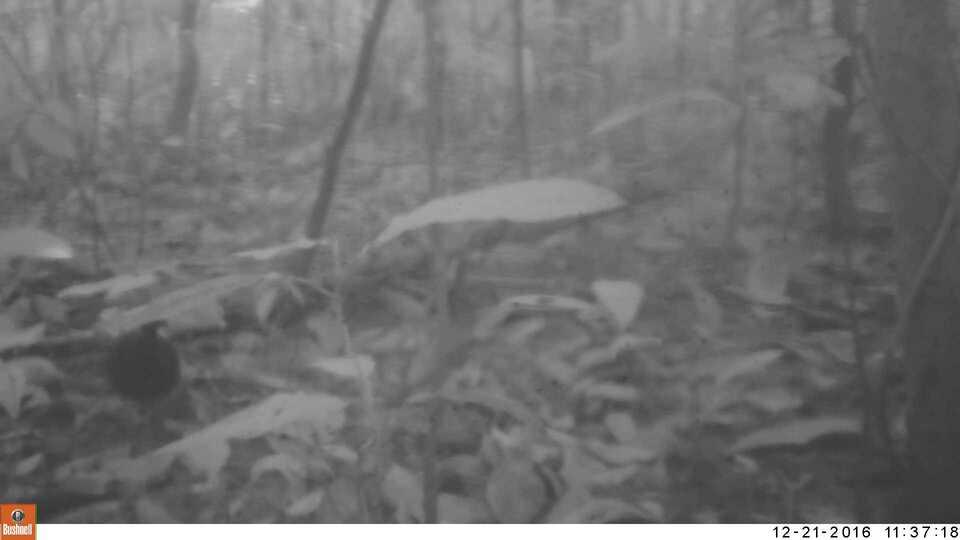

In [246]:
image = get_image_from_s3(bucket_name, os.path.join("processed", train_keys[0]))
image2 = get_image_from_s3(bucket_name, os.path.join("processed", train_keys[1]))
image

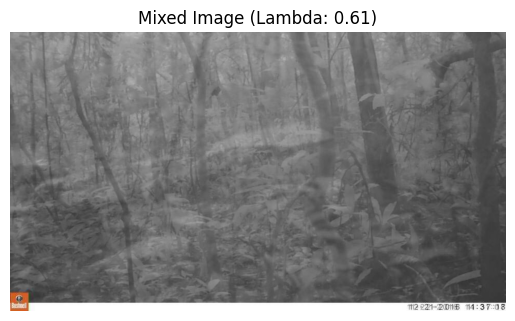

In [247]:
img1 = np.array(image)
img2 = np.array(image2)

# Ensure images are of type float for precise mixing
img1 = img1.astype(np.float32)
img2 = img2.astype(np.float32)

lambda_val = np.random.beta(0.4, 0.4)

mixed_image_np = (lambda_val * img1) + ((1 - lambda_val) * img2)

# Ensure the final array is clipped to valid pixel values (0-255) and cast back to uint8
mixed_image_np = np.clip(mixed_image_np, 0, 255).astype(np.uint8)

plt.imshow(mixed_image_np)
plt.axis('off') # Optional: hides axes and ticks for a cleaner look
plt.title(f"Mixed Image (Lambda: {lambda_val:.2f})")
plt.show()

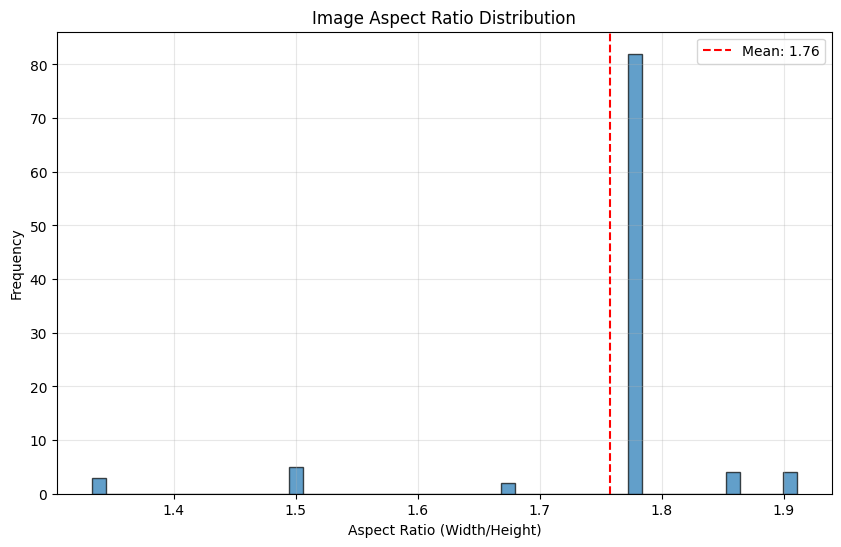

Aspect ratio stats:
  Min: 1.33
  Max: 1.91
  Mean: 1.76
  Std: 0.10


In [248]:
# After you create width and height arrays
aspect_ratios = width / height
plt.figure(figsize=(10, 6))
plt.hist(aspect_ratios, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.title('Image Aspect Ratio Distribution')
plt.axvline(aspect_ratios.mean(), color='red', linestyle='--', label=f'Mean: {aspect_ratios.mean():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Aspect ratio stats:")
print(f"  Min: {aspect_ratios.min():.2f}")
print(f"  Max: {aspect_ratios.max():.2f}")
print(f"  Mean: {aspect_ratios.mean():.2f}")
print(f"  Std: {aspect_ratios.std():.2f}")

In [249]:
col

Index(['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard',
       'monkey_prosimian', 'rodent'],
      dtype='object')

In [250]:
df_labels

id  antelope_duiker  bird  blank  civet_genet  hog  leopard  \
0      ZJ000000              0.0   1.0    0.0          0.0  0.0      0.0   
1      ZJ000001              0.0   0.0    0.0          0.0  0.0      0.0   
2      ZJ000002              0.0   1.0    0.0          0.0  0.0      0.0   
3      ZJ000003              0.0   0.0    0.0          0.0  0.0      0.0   
4      ZJ000004              0.0   0.0    0.0          0.0  0.0      1.0   
...         ...              ...   ...    ...          ...  ...      ...   
16483  ZJ016483              0.0   0.0    1.0          0.0  0.0      0.0   
16484  ZJ016484              0.0   0.0    0.0          0.0  0.0      1.0   
16485  ZJ016485              0.0   0.0    0.0          1.0  0.0      0.0   
16486  ZJ016486              0.0   1.0    0.0          0.0  0.0      0.0   
16487  ZJ016487              0.0   0.0    0.0          1.0  0.0      0.0   

       monkey_prosimian  rodent  
0                   0.0     0.0  
1                   1.0     0.0  
2                   0.0     0.0  
3                   1.0     0.0  
4                   0.0     0.0  
...                 ...     ...  
16483               0.0     0.0  
16484               0.0     0.0  
16485               0.0     0.0  
16486               0.0     0.0  
16487               0.0     0.0  

[16488 rows x 9 columns]

In [251]:
antelope_duiker_id = df_labels[df_labels['antelope_duiker'] == 1]['id']
antelope_duiker_id = antelope_duiker_id.astype(str) + ".jpg"
blank_id = df_labels[df_labels['blank'] == 1]['id']
blank_id = blank_id.astype(str) + ".jpg"
rodent_id = df_labels[df_labels['rodent'] == 1]['id']
rodent_id = rodent_id.astype(str) + ".jpg"
monkey_prosimian_id = df_labels[df_labels['monkey_prosimian'] == 1]['id']
monkey_prosimian_id = monkey_prosimian_id.astype(str) + ".jpg"


In [252]:
antelope_duiker_id

7        ZJ000007.jpg
22       ZJ000022.jpg
30       ZJ000030.jpg
37       ZJ000037.jpg
39       ZJ000039.jpg
             ...     
16452    ZJ016452.jpg
16458    ZJ016458.jpg
16461    ZJ016461.jpg
16474    ZJ016474.jpg
16481    ZJ016481.jpg
Name: id, Length: 2474, dtype: object

In [253]:
blank_id

13       ZJ000013.jpg
15       ZJ000015.jpg
18       ZJ000018.jpg
29       ZJ000029.jpg
41       ZJ000041.jpg
             ...     
16450    ZJ016450.jpg
16455    ZJ016455.jpg
16460    ZJ016460.jpg
16482    ZJ016482.jpg
16483    ZJ016483.jpg
Name: id, Length: 2213, dtype: object

In [254]:
os.path.join(train_folder, antelope_duiker_id.iloc[0])

'processed/train_features/ZJ000007.jpg'

In [255]:
train_folder

'processed/train_features'

In [256]:
bucket_name

'animal-classification-virgina'

In [257]:
l = s3.list_objects_v2(Bucket=bucket_name, Prefix=train_folder)

keys = []
print(f"Getting keys from {train_folder}")
if 'Contents' in l:
    for obj in l['Contents']:
        k = obj['Key']
        keys.append(k) # This prints the full key (path + filename)
        
else:
    print(f'No files found in s3://{bucket_name}/{train_folder}')

keys.remove(keys[0])
keys

Getting keys from processed/train_features


['processed/train_features/ZJ000000.jpg',
 'processed/train_features/ZJ000001.jpg',
 'processed/train_features/ZJ000002.jpg',
 'processed/train_features/ZJ000003.jpg',
 'processed/train_features/ZJ000004.jpg',
 'processed/train_features/ZJ000005.jpg',
 'processed/train_features/ZJ000006.jpg',
 'processed/train_features/ZJ000007.jpg',
 'processed/train_features/ZJ000008.jpg',
 'processed/train_features/ZJ000009.jpg',
 'processed/train_features/ZJ000010.jpg',
 'processed/train_features/ZJ000011.jpg',
 'processed/train_features/ZJ000012.jpg',
 'processed/train_features/ZJ000013.jpg',
 'processed/train_features/ZJ000014.jpg',
 'processed/train_features/ZJ000015.jpg',
 'processed/train_features/ZJ000016.jpg',
 'processed/train_features/ZJ000017.jpg',
 'processed/train_features/ZJ000018.jpg',
 'processed/train_features/ZJ000019.jpg',
 'processed/train_features/ZJ000020.jpg',
 'processed/train_features/ZJ000021.jpg',
 'processed/train_features/ZJ000022.jpg',
 'processed/train_features/ZJ00002

In [258]:
print(os.path.join(train_folder, antelope_duiker_id.iloc[1]))
print("s3://animal-classification-virgina/processed/train_features/ZJ000022.jpg")


processed/train_features/ZJ000022.jpg
s3://animal-classification-virgina/processed/train_features/ZJ000022.jpg


In [259]:
print(train_keys[1])
print(keys[3])

train_features/ZJ000001.jpg
processed/train_features/ZJ000003.jpg


processed/train_features/ZJ000007.jpg
processed/train_features/ZJ000022.jpg
processed/train_features/ZJ000030.jpg
processed/train_features/ZJ000037.jpg
processed/train_features/ZJ000039.jpg
processed/train_features/ZJ000043.jpg
processed/train_features/ZJ000049.jpg
processed/train_features/ZJ000057.jpg
processed/train_features/ZJ000065.jpg
processed/train_features/ZJ000067.jpg


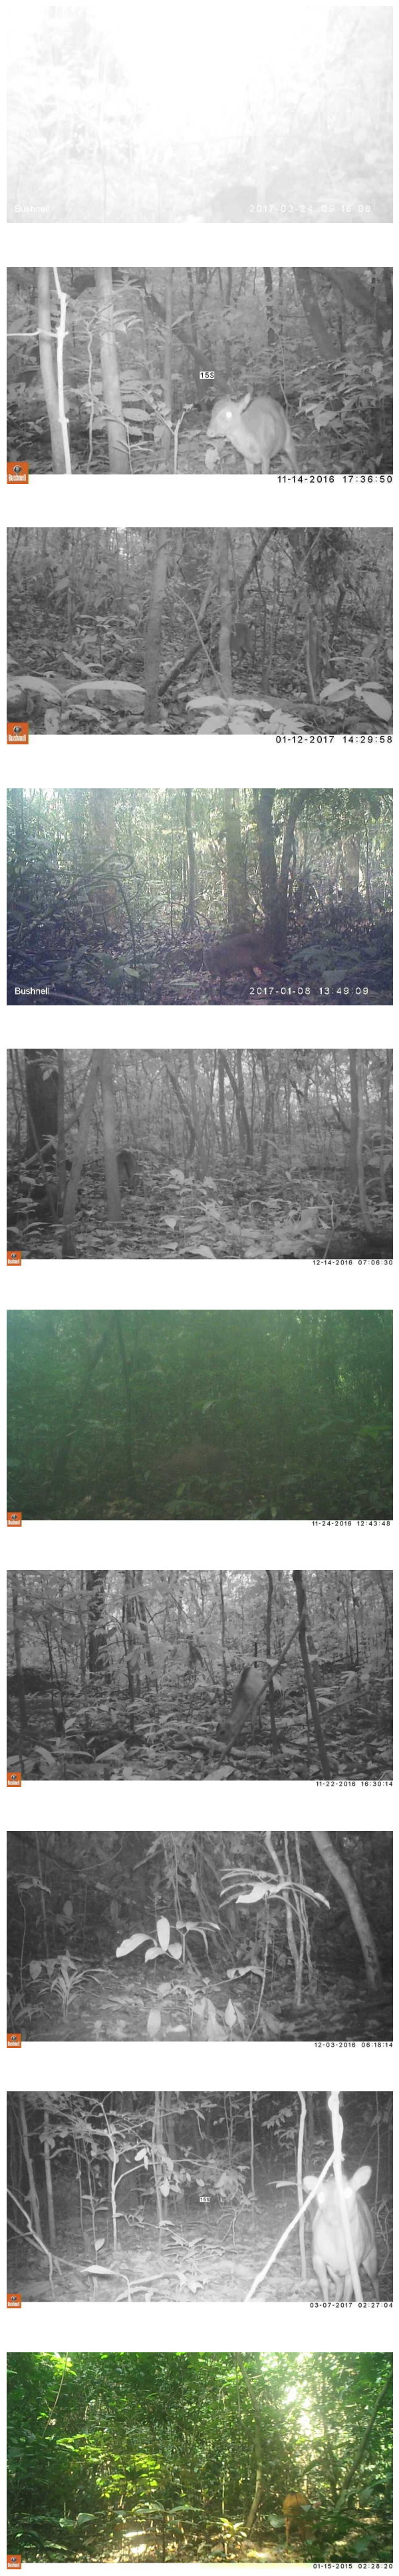

In [260]:
fig, ax = plt.subplots(10, 1, figsize=(50, 50))

for i in range(len(antelope_duiker_id)):
    if i == 10:
        break
    ant = get_image_from_s3(bucket_name, os.path.join(train_folder, antelope_duiker_id.iloc[i]))
    ax[i].imshow(ant,)
    ax[i].axis('off')
    
plt.show()


processed/train_features/ZJ000013.jpg
processed/train_features/ZJ000015.jpg
processed/train_features/ZJ000018.jpg
processed/train_features/ZJ000029.jpg
processed/train_features/ZJ000041.jpg
processed/train_features/ZJ000045.jpg
processed/train_features/ZJ000051.jpg
processed/train_features/ZJ000061.jpg
processed/train_features/ZJ000062.jpg
processed/train_features/ZJ000064.jpg


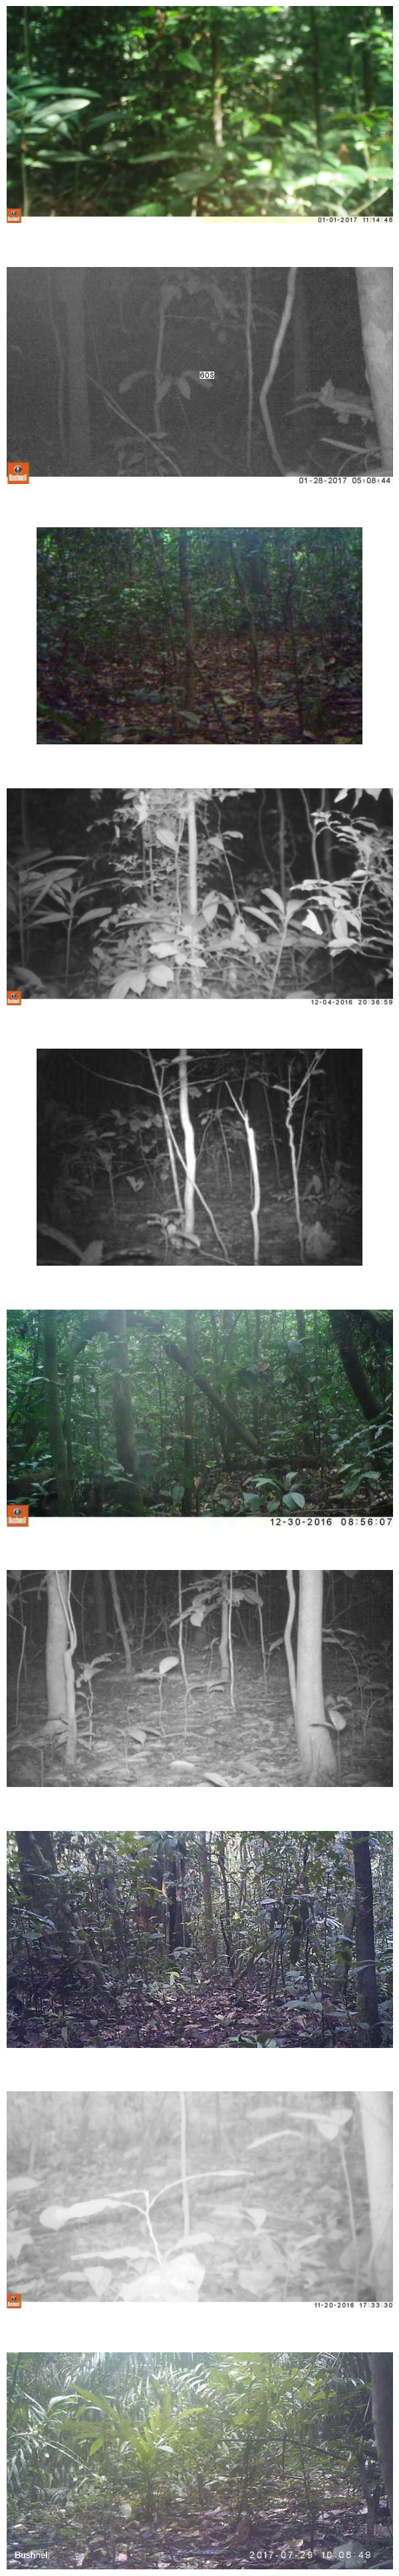

In [268]:
fig, ax = plt.subplots(10, 1, figsize=(50, 50))

for i in range(len(blank_id)):
    if i == 10:
        break
    ant = get_image_from_s3(bucket_name, os.path.join(train_folder, blank_id.iloc[i]))
    ax[i].imshow(ant,)
    ax[i].axis('off')
    
plt.show()


processed/train_features/ZJ000025.jpg
processed/train_features/ZJ000035.jpg
processed/train_features/ZJ000050.jpg
processed/train_features/ZJ000054.jpg
processed/train_features/ZJ000068.jpg


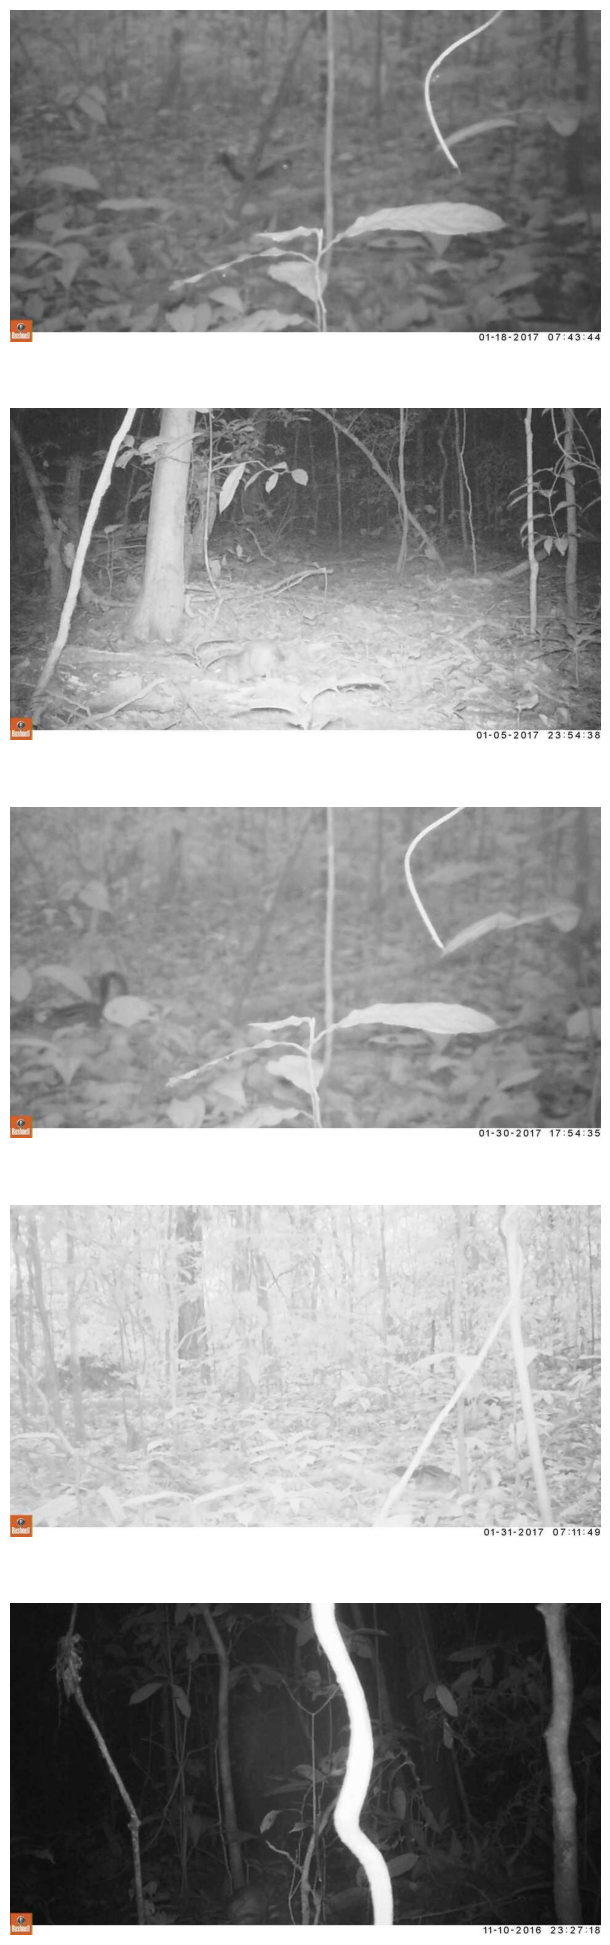

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(8, 25))

for i in range(len(rodent_id)):
    if i == 5:
        break
    ant = get_image_from_s3(bucket_name, os.path.join(train_folder, rodent_id.iloc[i]))
    ax[i].imshow(ant,)
    ax[i].axis('off')
    
plt.show()


processed/train_features/ZJ000001.jpg
processed/train_features/ZJ000003.jpg
processed/train_features/ZJ000012.jpg
processed/train_features/ZJ000014.jpg
processed/train_features/ZJ000019.jpg


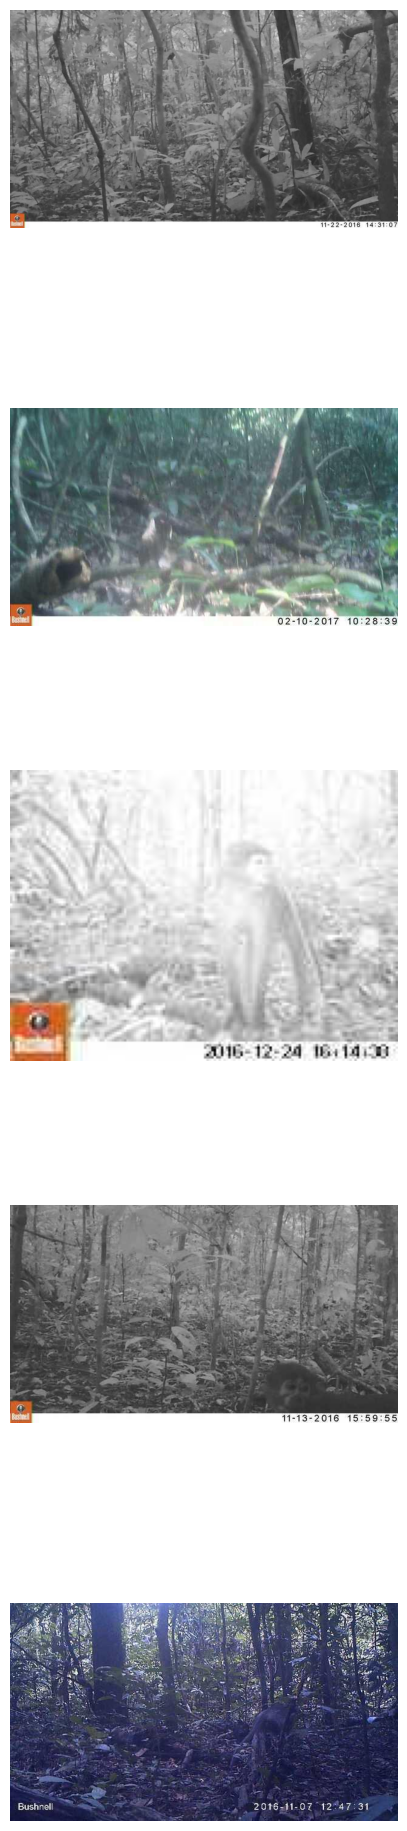

In [262]:
fig, ax = plt.subplots(5, 1, figsize=(5, 25))

for i in range(len(monkey_prosimian_id)):
    if i == 5:
        break
    ant = get_image_from_s3(bucket_name, os.path.join(train_folder, monkey_prosimian_id.iloc[i]))
    ax[i].imshow(ant,)
    ax[i].axis('off')
    
plt.show()



In [263]:
# correlation = pd.DataFrame(columns=['class_size', 'f1-score', "correlation"])

# for i in count:
    


In [264]:
count

{'antelope_duiker': 2474,
 'bird': 1641,
 'blank': 2213,
 'civet_genet': 2423,
 'hog': 978,
 'leopard': 2254,
 'monkey_prosimian': 2492,
 'rodent': 2013}

In [284]:
img_size = 224

jitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2)


train_transform = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
)

jitter_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    jitter,
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


processed/train_features/ZJ000003.jpg


/var/folders/4m/b6_cz0w13g31tffdygtbhty00000gn/T/ipykernel_76606/3498355961.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  print(np.array(image2).shape)
/var/folders/4m/b6_cz0w13g31tffdygtbhty00000gn/T/ipykernel_76606/3498355961.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  print(np.array(image2))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4842881..2.64].
Clipping input data to the 

(360, 640, 3)
[[[ 69 114 111]
  [ 72 117 114]
  [ 75 115 114]
  ...
  [108 160 158]
  [103 158 155]
  [101 156 153]]

 [[ 67 112 109]
  [ 71 116 113]
  [ 75 115 114]
  ...
  [108 160 158]
  [104 159 156]
  [103 158 155]]

 [[ 64 109 106]
  [ 68 113 110]
  [ 75 115 114]
  ...
  [110 162 160]
  [107 162 159]
  [105 160 157]]

 ...

 [[247 157 105]
  [200 108  57]
  [201 103  54]
  ...
  [247 255 255]
  [232 244 240]
  [245 255 255]]

 [[247 151 100]
  [214 114  64]
  [195  89  39]
  ...
  [216 228 224]
  [240 252 248]
  [235 250 245]]

 [[241 141  89]
  [228 127  75]
  [205  95  44]
  ...
  [239 251 247]
  [244 255 252]
  [232 247 242]]]
(3, 224, 224)
[[[-0.88492167 -1.0219197  -1.1760426  ... -0.09718303 -0.18280679
   -0.31980482]
  [-0.9362959  -0.95342064 -1.1931673  ... -0.01155927 -0.18280679
   -0.2855553 ]
  [-0.9705454  -0.91917115 -1.1931673  ...  0.03981499 -0.16568205
   -0.18280679]
  ...
  [ 1.3241715   1.1015497   1.0330508  ... -0.33692956 -0.38830382
    1.3584211 ]
  [ 

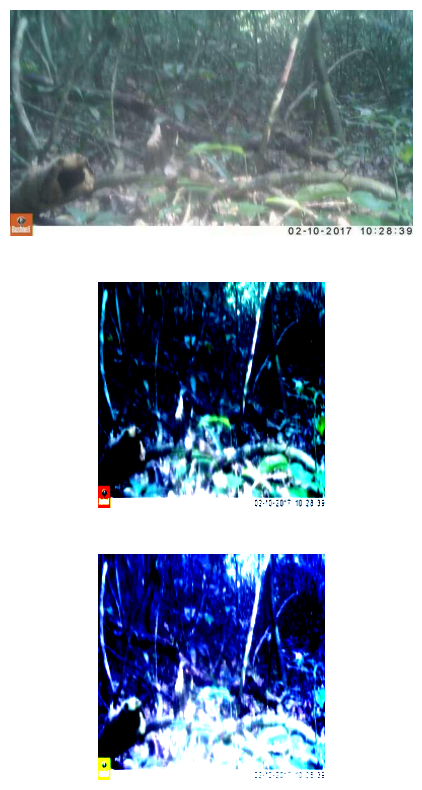

In [285]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

image1 = get_image_from_s3(bucket_name, os.path.join(train_folder, monkey_prosimian_id.iloc[1]))
print(np.array(image1).shape)
print(np.array(image1))

image2  = train_transform(image1)
image3 = jitter_transform(image1)
print(np.array(image2).shape)
print(np.array(image2))
ax[0].imshow(image1,)
ax[0].axis('off')
ax[1].imshow(image2.permute(1, 2, 0).cpu().numpy(), cmap='gray')
ax[1].axis('off')
ax[2].imshow(image3.permute(1, 2, 0).cpu().numpy(), cmap='gray')
ax[2].axis('off')
plt.show()

# Test NumpyEncoder for JSON Serialization

This cell demonstrates how the `NumpyEncoder` class converts numpy types to JSON-serializable Python types.


In [1]:
import json
import numpy as np
import pandas as pd
import os

# ============================================================
# NumpyEncoder: Handles numpy types for JSON serialization
# ============================================================
class NumpyEncoder(json.JSONEncoder):
    """Custom JSON encoder that converts numpy types to Python types."""
    def default(self, obj):
        if isinstance(obj, np.integer):      # np.int64 → int
            return int(obj)
        if isinstance(obj, np.floating):     # np.float64 → float
            return float(obj)
        if isinstance(obj, np.ndarray):      # numpy arrays → lists
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

# ============================================================
# Test Data: Create various numpy types
# ============================================================
print("=" * 60)
print("CREATING TEST DATA WITH NUMPY TYPES")
print("=" * 60)

# 1. Numpy scalars (common from sklearn metrics)
accuracy = np.float64(0.8523)
precision = np.float64(0.7891)
num_samples = np.int64(12366)

print(f"\n1. Numpy Scalars:")
print(f"   accuracy = {accuracy} (type: {type(accuracy).__name__})")
print(f"   precision = {precision} (type: {type(precision).__name__})")
print(f"   num_samples = {num_samples} (type: {type(num_samples).__name__})")

# 2. Numpy arrays (like confusion matrix, predictions)
confusion_matrix = np.array([
    [100, 10, 5],
    [8, 120, 12],
    [3, 15, 95]
])
predictions = np.array([0, 1, 2, 0, 1, 2, 1, 0])
probabilities = np.array([0.85, 0.72, 0.91, 0.68])

print(f"\n2. Numpy Arrays:")
print(f"   confusion_matrix shape: {confusion_matrix.shape} (type: {type(confusion_matrix).__name__})")
print(f"   predictions: {predictions} (type: {type(predictions).__name__})")
print(f"   probabilities: {probabilities} (type: {type(probabilities).__name__})")

# 3. Mixed dictionary (like training report)
test_report = {
    "epoch": 5,                                    # Python int (OK)
    "accuracy": accuracy,                          # numpy.float64 (PROBLEM without encoder)
    "precision": precision,                        # numpy.float64 (PROBLEM without encoder)
    "num_samples": num_samples,                    # numpy.int64 (PROBLEM without encoder)
    "confusion_matrix": confusion_matrix,          # numpy.ndarray (PROBLEM without encoder)
    "predictions_sample": predictions[:5],         # numpy.ndarray slice (PROBLEM without encoder)
    "class_scores": {
        "class_0": np.float64(0.85),              # nested numpy (PROBLEM without encoder)
        "class_1": np.float64(0.72),
        "class_2": np.float64(0.91),
    },
    "loss": 0.3456,                               # Python float (OK)
    "model_name": "swin_b",                       # Python string (OK)
}

print(f"\n3. Test Report Dictionary:")
for key, value in test_report.items():
    print(f"   {key}: {type(value).__name__}")

# ============================================================
# Test 1: Try saving WITHOUT NumpyEncoder (WILL FAIL!)
# ============================================================
print("\n" + "=" * 60)
print("TEST 1: Saving WITHOUT NumpyEncoder (Should Fail!)")
print("=" * 60)

try:
    json_string = json.dumps(test_report, indent=2)
    print("SUCCESS - This shouldn't happen!")
except TypeError as e:
    print(f"EXPECTED ERROR: {e}")

# ============================================================
# Test 2: Save WITH NumpyEncoder (WILL SUCCEED!)
# ============================================================
print("\n" + "=" * 60)
print("TEST 2: Saving WITH NumpyEncoder (Should Succeed!)")
print("=" * 60)

try:
    json_string = json.dumps(test_report, indent=2, cls=NumpyEncoder)
    print("SUCCESS! Converted to JSON:")
    print(json_string)
except TypeError as e:
    print(f"ERROR: {e}")

# ============================================================
# Test 3: Save to actual file
# ============================================================
print("\n" + "=" * 60)
print("TEST 3: Saving to actual JSON file")
print("=" * 60)

output_path = "test_numpy_encoder.json"
with open(output_path, 'w') as f:
    json.dump(test_report, f, indent=2, cls=NumpyEncoder)

print(f"File saved to: {output_path}")

# Read it back to verify
with open(output_path, 'r') as f:
    loaded_data = json.load(f)

print(f"\nLoaded back from file:")
print(f"   accuracy: {loaded_data['accuracy']} (type: {type(loaded_data['accuracy']).__name__})")
print(f"   confusion_matrix type: {type(loaded_data['confusion_matrix']).__name__}")
print(f"   class_scores['class_0']: {loaded_data['class_scores']['class_0']}")

# ============================================================
# Test 4: Verify all types are now Python native
# ============================================================
print("\n" + "=" * 60)
print("TEST 4: Verify types after JSON round-trip")
print("=" * 60)

print("\nBefore (numpy types):")
print(f"   accuracy: {type(test_report['accuracy']).__name__}")
print(f"   confusion_matrix: {type(test_report['confusion_matrix']).__name__}")
print(f"   num_samples: {type(test_report['num_samples']).__name__}")

print("\nAfter loading from JSON (Python native types):")
print(f"   accuracy: {type(loaded_data['accuracy']).__name__}")
print(f"   confusion_matrix: {type(loaded_data['confusion_matrix']).__name__}")
print(f"   num_samples: {type(loaded_data['num_samples']).__name__}")

print("\n" + "=" * 60)
print("ALL TESTS PASSED!")
print("=" * 60)

# Clean up test file
os.remove(output_path)
print(f"\nCleaned up: {output_path}")

CREATING TEST DATA WITH NUMPY TYPES

1. Numpy Scalars:
   accuracy = 0.8523 (type: float64)
   precision = 0.7891 (type: float64)
   num_samples = 12366 (type: int64)

2. Numpy Arrays:
   confusion_matrix shape: (3, 3) (type: ndarray)
   predictions: [0 1 2 0 1 2 1 0] (type: ndarray)
   probabilities: [0.85 0.72 0.91 0.68] (type: ndarray)

3. Test Report Dictionary:
   epoch: int
   accuracy: float64
   precision: float64
   num_samples: int64
   confusion_matrix: ndarray
   predictions_sample: ndarray
   class_scores: dict
   loss: float
   model_name: str

TEST 1: Saving WITHOUT NumpyEncoder (Should Fail!)
EXPECTED ERROR: Object of type int64 is not JSON serializable

TEST 2: Saving WITH NumpyEncoder (Should Succeed!)
SUCCESS! Converted to JSON:
{
  "epoch": 5,
  "accuracy": 0.8523,
  "precision": 0.7891,
  "num_samples": 12366,
  "confusion_matrix": [
    [
      100,
      10,
      5
    ],
    [
      8,
      120,
      12
    ],
    [
      3,
      15,
      95
    ]
  ],
  "p